# Escuela Colombiana de Ingeniería Julio Garavito

## Programming for Data Analysis - Final Project

## Authors: Juan Pablo Sánchez Bermúdez - Juan Camilo Bazurto Arias


## Objetive:
From an open-source dataset, implement different types of analysis, such as exploratory, descriptive, andinferential. The implementation can be using R or Python from an SQL database.

<hr/>
    <div class="alert alert-success alertsuccess" style="margin-top: 20px">
        <h4> Before start </h4>
        <p>Install the following libraries if you have not installed these libraries.</p>
        <p><code>!pip install pandas</code></p>
        <p><code>!pip install matplotlib</code></p>
        <p><code>!pip install numpy</code></p>
        <p><code>!pip install seaburn</code></p>
        <p><code>!pip install sqlalchemy</code></p>
        <p><code>!pip install pymysql</code></p>
        <p><code>!pip install mysql.connector</code></p>
        <p><code>!pip install scipy</code></p>
    </div>
<hr/>

In [1]:
# Imports
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine, text
import pymysql
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import beta, binom

## Project stages:

### 1. Data Source Selection
Select one dataset from the above open data sources or any other relevant data source.

Considerations:The dataset should be rich enough to allow multiple analyses and should be relevantto the student’s interests or our course objectives.

The selected data set was [2023 NBA Playoff Predictions](https://www.kaggle.com/datasets/ethanchen44/nba-playoff-predictions) where only the 'nba_games.csv' data set will be used.

### 2. Loading the dataset into a SQL
Load the data set into a relational table designed in SQL database.  The Professor must providethe information on a connection.

Considerations: You can use the MySQL account provided by the professor, which is freely accessibleand will always be available while the course ends.

In [2]:
# Database connection
path = "nba_games.csv"
df = pd.read_csv(path)
username = "JSANCHEZ"
passwd = "JSANCHEZ"
host = "desarrollo.is.escuelaing.edu.co"
database = "JSANCHEZ"
cnx = create_engine(f'mysql+pymysql://{username}:{passwd}@{host}:3306/{database}')

# Load dataframe into the database
df.to_sql("NBA_PGAD", con=cnx, if_exists='replace', index=False)

3275

In [3]:
# Query connection
cnxquery = mysql.connector.connect(host = host ,user = username, password = passwd, database = database)

query = "SELECT * FROM NBA_PGAD"
result = pd.read_sql(query, cnxquery)
result

,home_team,home_team_short,matchup_id,home_points,home_fg_pct,home_ft_pct,home_fg3_pct,away_team,away_team_short,away_points,away_fg_pct,away_ft_pct,away_fg3_pct,winning_team
0,Boston Celtics,BOS,22201216,120,0.472,0.786,0.463,Atlanta Hawks,ATL,114,0.454,0.789,0.282,BOS
1,Phoenix Suns,PHX,22201229,114,0.424,0.727,0.378,LA Clippers,LAC,119,0.490,0.667,0.217,LAC
2,Denver Nuggets,DEN,22201227,109,0.500,0.720,0.250,Sacramento Kings,SAC,95,0.435,0.667,0.256,DEN
3,Minnesota Timberwolves,MIN,22201225,113,0.476,0.710,0.361,New Orleans Pelicans,NOP,108,0.444,0.862,0.143,MIN
4,Oklahoma City Thunder,OKC,22201226,115,0.500,0.813,0.333,Memphis Grizzlies,MEM,100,0.435,0.722,0.189,OKC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3270,Toronto Raptors,TOR,21700847,115,0.467,0.783,0.371,Miami Heat,MIA,112,0.488,0.842,0.414,TOR
3271,Milwaukee Bucks,MIL,21700848,97,0.432,0.765,0.320,Atlanta Hawks,ATL,92,0.384,0.700,0.343,MIL
3272,Golden State Warriors,GSW,21700846,129,0.584,0.667,0.423,Phoenix Suns,PHX,83,0.347,0.636,0.130,GSW
3273,Brooklyn Nets,BKN,21700843,101,0.461,0.700,0.300,LA Clippers,LAC,114,0.565,0.857,0.375,LAC


### 3. Data Preparation
Load, clean, and preprocess the selected dataset using programming-based tools and libraries.

Considerations: Ensure the data is ready for analysis, handle missing values, encode categorical vari-ables, and normalize or standardize numerical variables as necessary.

In [4]:
# Check for missing values
result.isnull().sum()

home_team          0
home_team_short    0
matchup_id         0
home_points        0
home_fg_pct        0
home_ft_pct        1
home_fg3_pct       1
away_team          0
away_team_short    0
away_points        0
away_fg_pct        1
away_ft_pct        1
away_fg3_pct       2
winning_team       0
dtype: int64

Since there are missing values, let's fill them using the median method.

In [5]:
# Function to fill missing values
def fillNa(df, cnxquery):
    size = df.shape
    rows = size[0]
    columns = size[1]
    columnNames = df.columns
    c = cnxquery.cursor()
    for row in range(rows):
        for column in range(columns):
            if pd.isna(df.iloc[row, column]):
                if column < 8:
                    col = 1 # query home median team
                else:
                    col = 8 # query away median team
                q = "SELECT " + columnNames[column] + " FROM NBA_PGAD WHERE home_team_short = " + "'" + df.iloc[row, col] + "'"
                result = pd.read_sql(q, cnxquery)
                c.execute("UPDATE NBA_PGAD SET " + columnNames[column] + " = " + 
                          str(result[columnNames[column]].median()) + " WHERE matchup_id = " + str(df.iloc[row, 2]))

In [6]:
fillNa(result, cnxquery)
query = "SELECT * FROM NBA_PGAD"
result = pd.read_sql(query, cnxquery)
result.isnull().sum()

home_team          0
home_team_short    0
matchup_id         0
home_points        0
home_fg_pct        0
home_ft_pct        0
home_fg3_pct       0
away_team          0
away_team_short    0
away_points        0
away_fg_pct        0
away_ft_pct        0
away_fg3_pct       0
winning_team       0
dtype: int64

In [7]:
# Normalize the numerical variables using the Min-Max technique
numerical_features = ['home_fg_pct', 'home_ft_pct', 'home_fg3_pct', 'away_fg_pct', 'away_ft_pct', 'away_fg3_pct']
newdf = result.copy()
for feature in numerical_features:
    newdf[feature] = (newdf[feature] - newdf[feature].min()) / (newdf[feature].max() - newdf[feature].min())
newdf.head()

,home_team,home_team_short,matchup_id,home_points,home_fg_pct,home_ft_pct,home_fg3_pct,away_team,away_team_short,away_points,away_fg_pct,away_ft_pct,away_fg3_pct,winning_team
0,Boston Celtics,BOS,22201216,120,0.380789,0.679160,0.643056,Atlanta Hawks,ATL,114,0.703876,0.683658,0.298319,BOS
1,Phoenix Suns,PHX,22201229,114,0.298456,0.590705,0.525000,LA Clippers,LAC,119,0.759690,0.500750,0.207283,LAC
2,Denver Nuggets,DEN,22201227,109,0.428816,0.580210,0.347222,Sacramento Kings,SAC,95,0.674419,0.500750,0.261905,DEN
3,Minnesota Timberwolves,MIN,22201225,113,0.387650,0.565217,0.501389,New Orleans Pelicans,NOP,108,0.688372,0.793103,0.103641,MIN
4,Oklahoma City Thunder,OKC,22201226,115,0.428816,0.719640,0.462500,Memphis Grizzlies,MEM,100,0.674419,0.583208,0.168067,OKC


### 4. Exporatory Data Analysis (EDA)
Perform an initial dataset analysis using visualization techniques and statistical methods to gaininsights and identify patterns, trends, and potential relationships between variables.

Deliverable: An EDA report containing visualizations and observations about the dataset.

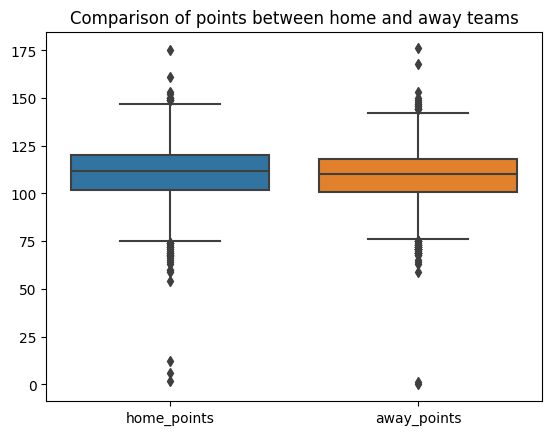

In [8]:
sns.boxplot(data=result[['home_points', 'away_points']])
plt.title("Comparison of points between home and away teams")
plt.show()

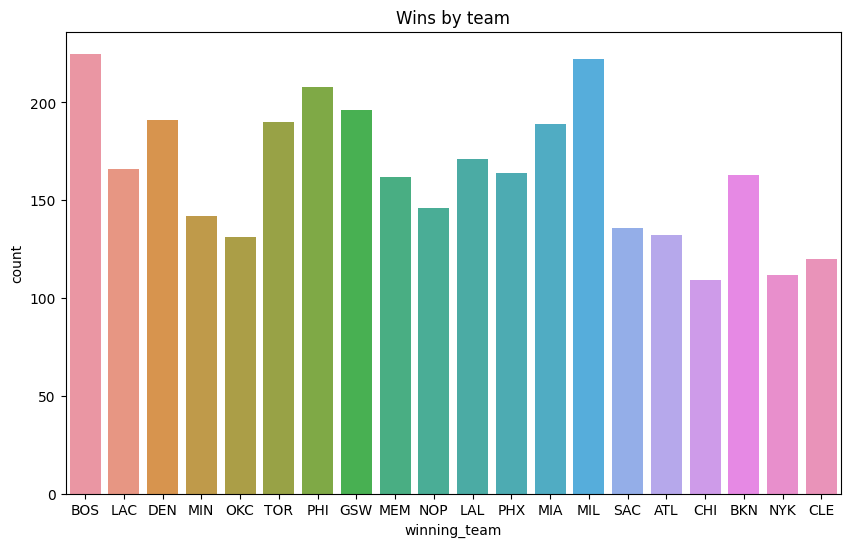

In [9]:
# Wins by team
plt.figure(figsize=(10,6))
sns.countplot(x='winning_team', data=result)
plt.title("Wins by team")
plt.show()

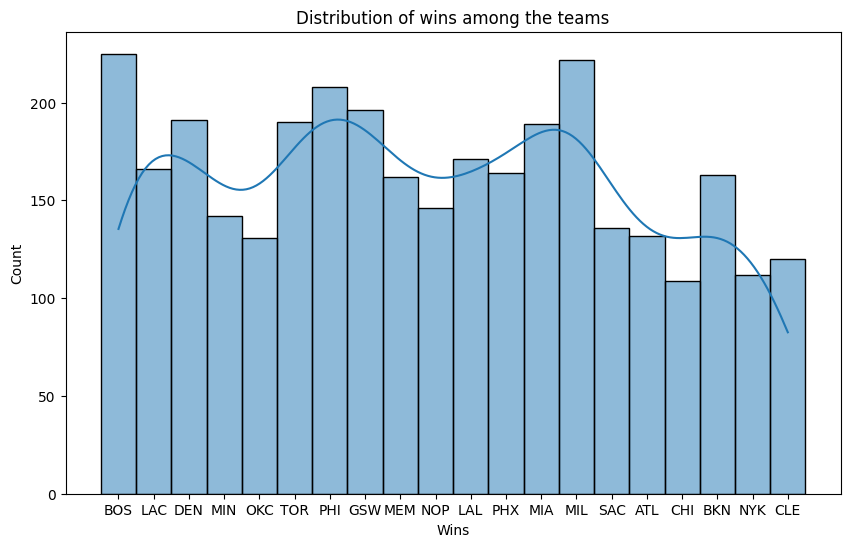

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(data=result, x='winning_team', kde=True)
plt.xlabel("Wins")
plt.title("Distribution of wins among the teams")
plt.show()

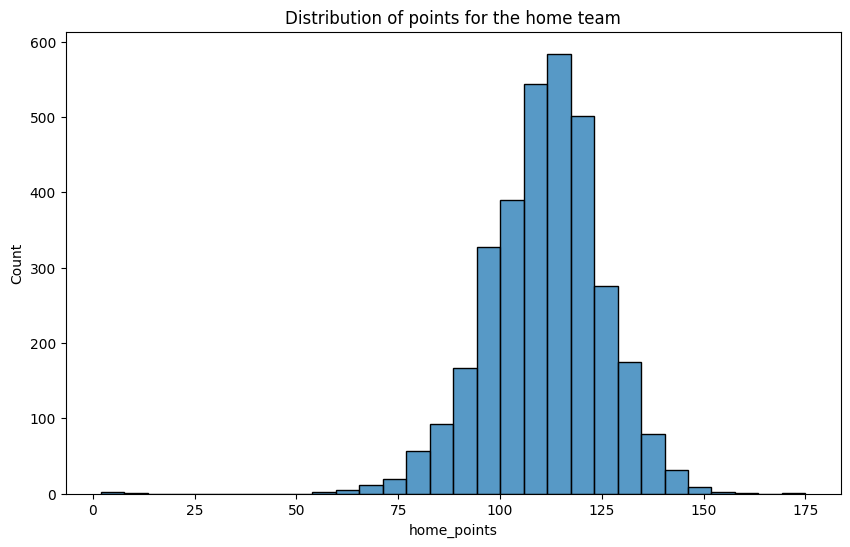

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(result['home_points'], kde=False, bins=30)
plt.title("Distribution of points for the home team")
plt.show()

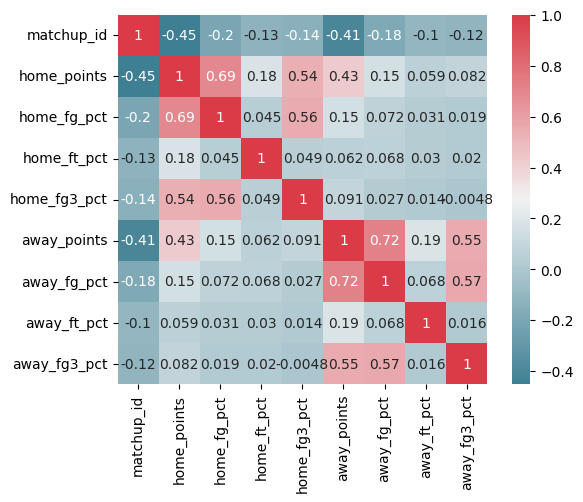

In [12]:
corr = df.corr()
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, annot=True)
plt.show()

Enter the teams's short name: BOS


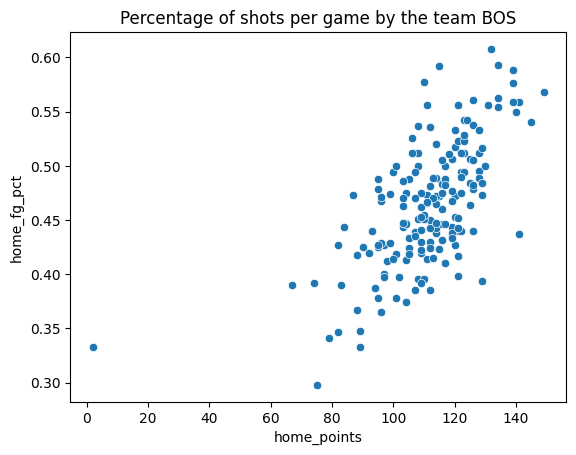

In [13]:
team_name = input("Enter the teams's short name: ")
data_home = df[df['home_team_short'] == team_name][['home_points', 'home_fg_pct']]
sns.scatterplot(data=data_home, x='home_points', y='home_fg_pct')
plt.title("Percentage of shots per game by the team " + team_name)
plt.show()

### 5. Descriptive Analysis
Calculate  summary  statistics  for  the  dataset,  such  as  means,  medians,  standard  deviations, quartiles, and correlations, to provide a quantitative data description.

Deliverable: A report describing the key statistics of the dataset and their implications.

In [14]:
result.describe()

,matchup_id,home_points,home_fg_pct,home_ft_pct,home_fg3_pct,away_points,away_fg_pct,away_ft_pct,away_fg3_pct
count,3.275000e+03,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000,3275.000000
mean,1.006361e+08,111.029008,0.464505,0.773180,0.357611,109.145954,0.457952,0.770838,0.352614
std,3.297949e+08,14.204784,0.056878,0.101211,0.085977,13.569773,0.055541,0.103105,0.085604
min,1.180000e+07,2.000000,0.250000,0.333000,0.000000,0.000000,0.000000,0.333000,0.069000
25%,2.180114e+07,102.000000,0.425000,0.714000,0.300000,101.000000,0.421000,0.708000,0.294000
50%,2.200075e+07,112.000000,0.464000,0.778000,0.357000,110.000000,0.457000,0.778000,0.351000
75%,2.220032e+07,120.000000,0.500000,0.844000,0.417000,118.000000,0.494000,0.842000,0.406000
max,1.622200e+09,175.000000,0.833000,1.000000,0.720000,176.000000,0.645000,1.000000,0.783000


* Home teams score an average of 111 points (mean->home_points), while away teams score an average of 109 points (mean->away_points). This may suggest that home teams tend to perform better than away teams.

* The free throw percentages (home_ft_pct and away_ft_pct) have a higher average, indicating that teams tend to be more successful in this type of shot.

In [15]:
result.corr()

,matchup_id,home_points,home_fg_pct,home_ft_pct,home_fg3_pct,away_points,away_fg_pct,away_ft_pct,away_fg3_pct
matchup_id,1.000000,-0.452182,-0.204748,-0.125761,-0.142172,-0.411819,-0.184103,-0.103410,-0.114987
home_points,-0.452182,1.000000,0.691535,0.178974,0.534490,0.431130,0.152991,0.058869,0.081385
home_fg_pct,-0.204748,0.691535,1.000000,0.044786,0.551581,0.150489,0.072242,0.030660,0.019050
home_ft_pct,-0.125761,0.178974,0.044786,1.000000,0.048415,0.062152,0.068651,0.030340,0.020316
home_fg3_pct,-0.142172,0.534490,0.551581,0.048415,1.000000,0.089324,0.026341,0.013015,-0.005563
away_points,-0.411819,0.431130,0.150489,0.062152,0.089324,1.000000,0.713916,0.185589,0.541035
away_fg_pct,-0.184103,0.152991,0.072242,0.068651,0.026341,0.713916,1.000000,0.068652,0.559690
away_ft_pct,-0.103410,0.058869,0.030660,0.030340,0.013015,0.185589,0.068652,1.000000,0.015481
away_fg3_pct,-0.114987,0.081385,0.019050,0.020316,-0.005563,0.541035,0.559690,0.015481,1.000000


* Free throw percentages don't seem to be strongly correlated with the points scored by home and away teams. This could be because free throws don't occur as frequently in a game compared to field goals and three-pointers.

* The variables that are most correlated are the points scored along with the field goal percentage, especially in away teams. This may suggest that away teams tend to be more effective in their shots despite scoring fewer points than home teams.

### 6. Inferential Analysis or Predictive Modeling
Use inferential statistics or machine learning algorithms to make predictions or draw conclusionsbased on the data.

Deliverable: A report detailing the model selection, evaluation, and interpretation of the results, alongwith any actionable insights or recommendations.

#### Team Statistics Calculation
We calculate the number of games won and lost by each team during the season.

In [16]:
home_team_shorts = set(result['home_team_short'].unique())
away_team_shorts = set(result['away_team_short'].unique())
team_shorts = home_team_shorts.union(away_team_shorts)

wins = {}
losses = {}

for team in team_shorts:
    home_wins = result[(result['home_team_short'] == team) & (result['winning_team'] == team)].shape[0]
    away_wins = result[(result['away_team_short'] == team) & (result['winning_team'] == team)].shape[0]
    home_losses = result[(result['home_team_short'] == team) & (result['winning_team'] != team)].shape[0]
    away_losses = result[(result['away_team_short'] == team) & (result['winning_team'] != team)].shape[0]

    wins[team] = home_wins + away_wins
    losses[team] = home_losses + away_losses

team_wins_losses = pd.DataFrame({'wins': wins, 'losses': losses})
team_wins_losses

,wins,losses
LAL,171,174
PHI,208,141
LAC,166,157
MEM,162,156
MIL,222,139
NYK,112,180
SAC,136,172
BOS,225,148
MIA,189,169
CHI,109,190


#### Creation of the Bayesian model
The prior distribution is updated with the results of each game to obtain the posterior distribution, which in turn informs the predictions for the upcoming games.

In [17]:
# Use the Beta distribution as a prior, assuming that, a priori, all teams have an equal probability of winning
alpha_prior = 1
beta_prior = 1

# Simulates a match between two teams
team1 = input("Enter the short name for team 1: ")
team2 = input("Enter the short name for team 2: ")

# Obtain the wins and losses of the teams
team1_wins = team_wins_losses.loc[team1, 'wins']
team1_losses = team_wins_losses.loc[team1, 'losses']
team2_wins = team_wins_losses.loc[team2, 'wins']
team2_losses = team_wins_losses.loc[team2, 'losses']

team1_posterior = beta(alpha_prior + team1_wins, beta_prior + team1_losses)
team2_posterior = beta(alpha_prior + team2_wins, beta_prior + team2_losses)

# Function to calculate the probability of a team winning
def win_probability(team1_posterior, team2_posterior, n_samples=10000):
    samples_team1 = team1_posterior.rvs(n_samples)  # .rvs generates random samples from the distribution
    samples_team2 = team2_posterior.rvs(n_samples)
    return np.mean(samples_team1 > samples_team2)


team1_win_prob = win_probability(team1_posterior, team2_posterior)
team2_win_prob = win_probability(team2_posterior, team1_posterior)

tasa_team1 = team_wins_losses.loc[team1, 'wins'] / (
        team_wins_losses.loc[team1, 'wins'] + team_wins_losses.loc[team1, 'losses'])
tasa_team2 = team_wins_losses.loc[team2, 'wins'] / (
        team_wins_losses.loc[team2, 'wins'] + team_wins_losses.loc[team2, 'losses'])

if team1_win_prob > team2_win_prob:
    print(f"The {team1} team has a rate of {tasa_team1 * 100:.2f}% and a probability of {team1_win_prob * 100:.2f}%"
          f" of winning the next game.")
elif team1_win_prob < team2_win_prob:
    print(f"The {team2} team has a rate of {tasa_team2 * 100:.2f}% and a probability of {team2_win_prob * 100:.2f}%"
          f" of winning the next game.")
else:
    print("Both teams have an equal probability of winning the next game.")

Enter the short name for team 1: BOS
Enter the short name for team 2: MIL
The MIL team has a rate of 61.50% and a probability of 62.57% of winning the next game.


#### Simulation of the NBA season
A simulation of the NBA season is conducted. At each step of the simulation, the model is used to predict the outcome of a game, and then it is updated accordingly.

In [18]:
# Initializes the alpha and beta parameters for each team
alpha_params = {team: wins + 1 for team, wins in team_wins_losses['wins'].items()}
beta_params = {team: losses + 1 for team, losses in team_wins_losses['losses'].items()}

# Empty DataFrame to store the predictions
df_predictions = pd.DataFrame(columns=['home_team_short', 'away_team_short', 'winning_team', 'predicted_probability'])

# Simulates a new season with the games from the previous one
for i, row in result.iterrows():
    home_team = row['home_team_short']
    away_team = row['away_team_short']

    # Calculates the posterior
    home_posterior = beta(alpha_params[home_team], beta_params[home_team])
    away_posterior = beta(alpha_params[away_team], beta_params[away_team])

    # Calculatse the probability of the home team winning
    win_probability = home_posterior.mean() / (home_posterior.mean() + away_posterior.mean())

    # Stores the prediction for the new game
    new_match_predicted = pd.DataFrame({'home_team_short': [home_team],
                                        'away_team_short': [away_team],
                                        'winning_team': [row['winning_team']],
                                        'predicted_probability': [win_probability]})

    df_predictions = pd.concat([df_predictions, new_match_predicted], ignore_index=True)

    # print(f"The probability of {home_team} team wins over {away_team} team is {win_probability}")

    # Updates the alpha and beta parameters based on the game's outcome
    if row['winning_team'] == home_team:
        alpha_params[home_team] += 1
    else:
        beta_params[home_team] += 1

    if row['winning_team'] == away_team:
        alpha_params[away_team] += 1
    else:
        beta_params[away_team] += 1

#### Visualization of the results
Finally, the simulation results are visualized.

Enter the teams's short name: MIL


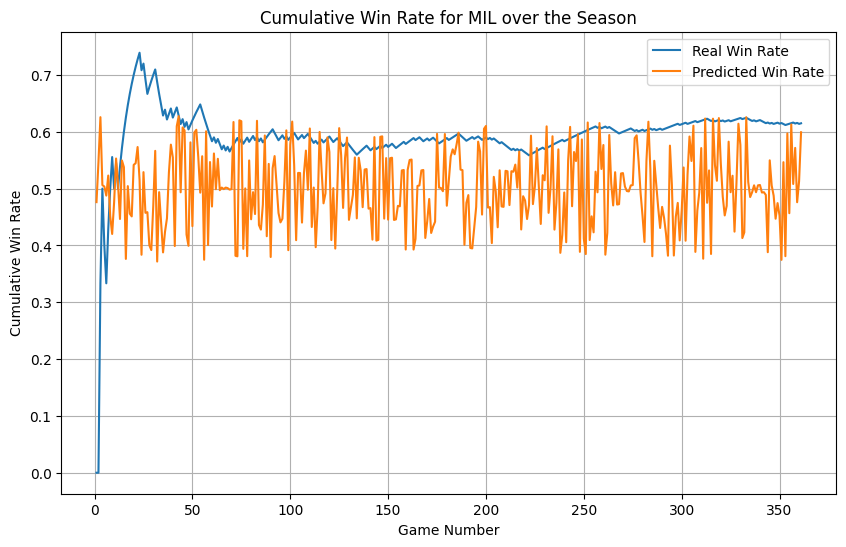

In [19]:
def plot_team_performance(df_predictions, team):
    # Filters the games of the entered team
    team_games = df_predictions[(df_predictions['home_team_short'] == team) |
                                (df_predictions['away_team_short'] == team)].copy()

    # Calculates the sum of games played and games won
    team_games['game_number'] = range(1, len(team_games) + 1)
    team_games['cumulative_wins'] = (team_games['winning_team'] == team).cumsum()

    # Calculate the cumulative win rate
    team_games['cumulative_win_rate'] = team_games['cumulative_wins'] / team_games['game_number']

    # Graph of the cumulative win rate
    plt.figure(figsize=(10, 6))
    plt.plot(team_games['game_number'], team_games['cumulative_win_rate'], label='Real Win Rate')

    # Graph of the predictive probability of winning
    if 'predicted_probability' in team_games.columns:
        plt.plot(team_games['game_number'], team_games['predicted_probability'], label='Predicted Win Rate')

    plt.xlabel('Game Number')
    plt.ylabel('Cumulative Win Rate')
    plt.title(f'Cumulative Win Rate for {team} over the Season')
    plt.legend()
    plt.grid(True)
    plt.show()

team_name = input("Enter the teams's short name: ")
plot_team_performance(df_predictions, team_name)